## Data Science Coding Assessment
*This project is a derivative of coding assessment I took as a part of the hiring process for candidates at a company. While the sample problem presented here can be found online, it is not the assessment I took but very similar.*

---

### Assessment Summary
This project aim is to develop a better classifier for classifying individuals' BMI based on their eating and physical activities using data-driven models.  

*Limitations*  

The limitation of this project is that Body Mass Index (BMI) is used to identify individuals who are underweight, healthy, overweight, and obese for the analysis. BMI may not always accurately classify individuals as it does not directly measure body fat.

#### Python Modules
The tool that will be used to fascinate in the modeling of the data was `Python`. The main packages used for data wrangling, visualization, and analysis were listed below. 

In [ ]:
!pip install dython

In [46]:
import pandas as pd
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from dython.nominal import associations
from dython.model_utils import metric_graph

from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
print("All modules loaded.")

All modules loaded.


##### Data Exploration

In [47]:
# set seed
np.random.seed(525)
seed = 525

# set gloab plot style
matplotlib.rcParams["figure.dpi"] = 100
plt.style.use('ggplot')

# set filepath for data ingestion
urlRemote  = "https://raw.githubusercontent.com/"
pathGithub = "greeneyefirefly/DATA622-Machine_Learning/main/"
fileName = "ObesityDataSet.csv"

# load dataset
data = pd.read_csv(urlRemote+pathGithub+fileName, index_col = None) # indicate index col if any

# Transform to category
for col in ["Gender","family_history","FAVC" ,"CAEC","SMOKE","SCC" ,"CALC","MTRANS","NObeyesdad"]:
    data[col] = data[col].astype('object')
    
# Ordinal transform
for col in ["FCVC","NCP","CH2O","FAF","TUE"]:
    data[col] = data[col].apply(np.ceil)
    data[col] = data[col].astype('object')

In [48]:
data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


This dataset is provided by Fabio Palechor and Alexis Manotas from the Universidad de la Costa, CUC, Colombia. It can be found on [UCI Machine Learning Repository](!https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). It includes the estimation of obesity levels in individuals from the countries of Mexico, Peru, and Colombia, based on their eating habits and physical condition. 

The data contains 17 attributes and 2111 records. The records are labeled with the class variable `NObesity` (Obesity Level), which allows the classification of the data using the BMI of an individual. BMI is an indicator of the amount of body fat of a person. It is a measure of one's body weight to their height. It is a tool that can assess a person's risk of diseases such as obesity and be underweight. According to the National Heart, Lung, and Blood Institute, BMI values

* less than 18.5 $kg/m^2$ are considered underweight,
* from 18.5 $kg/m^2$ to 24.9 $kg/m^2$ are healthy,
* from 25.0 to less than 30.0 $kg/m^2$ are considered to be overweight, and
* greater than 30.0 $kg/m^2$ are considered to be obese.

The formula for calculating the Body Mass Index is: $BMI = \frac{weight(kg)}{height^2(m^2)}$. The data further splits being overweight into two levels (I and II) and being obese into three levels (I, II, and III) according to WHO and the Mexican Normativity (Palechor, F. M., et al, 2019). 

*Features and Descriptions*

Category | Feature | Description | Variable Type  
----|---|------|--  
Target Variable |	NObesity |	Based on BMI | Categorical  
Eating Habits |	FAVC | Frequent consumption of high caloric food | Categorical  
Eating Habits |	FCVC | Frequency of consumption of vegetables |	Ordinal  
Eating Habits |	NCP |	Number of main meals | Ordinal  
Eating Habits |	CAEC | Consumption of food between meals | Ordinal  
Eating Habits |	CH20 | Consumption of water daily |	Ordinal  
Eating Habits | CALC | Consumption of alcohol | Ordinal  
Physical Conditioning |	SCC |	Calories consumption monitoring |	Categorical  
Physical Conditioning |	FAF |	Physical activity frequency | Ordinal  
Physical Conditioning |	TUE |	Time using technology devices |	Ordinal  
Physical Conditioning |	MTRANS | Transportation used | Categorical  
Physical Conditioning |	SMOKE |	Smokes | Categorical  
Respondent Characteristics | family_history | Family History with Overweight | Categorical  
Respondent Characteristics | Gender	| Gender | Categorical  
Respondent Characteristics | Age | Age in years | Integer  
Respondent Characteristics | Height |	Height in meters | Float  
Respondent Characteristics | Weight	| Weight in kilograms |	Float    

###### Feature Engineering : Calculating the BMI 

In [49]:
# Calculating the BMI 
data['BMI'] = data['Weight']/(data['Height']**2)

# Categorizing the BMI calculated from the actual measurements.
bins = [-np.inf, 18.5, 25, 30, np.inf]
labels = ["underweight", "healthy", "overweight", "obese"]
data['Obesity_4f'] = pd.cut(data['BMI'], bins = bins, labels = labels).astype('object')
data = data.drop(columns = 'NObeyesdad')

In [50]:
data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Obesity_4f
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,24.386526,healthy
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,24.238227,healthy
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,23.765432,healthy
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,26.851852,overweight
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,28.342381,overweight


---
#### Target Variable

The target feature is the individual BMI category of being health - obese. Their distribution among the categories can be considered well-balanced.

Text(0.5, 0, 'BMI category')

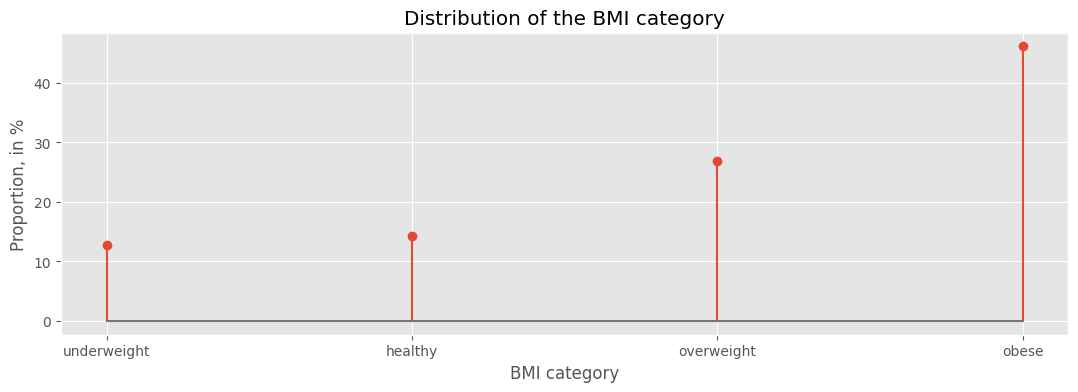

In [51]:
temp = pd.DataFrame(data['Obesity_4f'].value_counts(normalize = True)*100).reset_index().reindex([3,2,1,0])
plt.figure(figsize=(13,4))
plt.stem(temp['index'], temp['Obesity_4f'])
plt.title("Distribution of the BMI category")
plt.ylabel("Proportion, in %") 
plt.xlabel("BMI category")

---
#### Predictive Variables

##### Summary 

Based on the exploratory analysis for the data, some initial observations can be made. Firstly, the data set has complete cases, thus, there was no need for imputation. `Age` appears to be highly skewed, and will need data transformation to satisfy the assumption of normality. 

In [52]:
data.describe()

,Age,Height,Weight,BMI
count,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,29.700159
std,6.345968,0.093305,26.191172,8.011337
min,14.000000,1.450000,39.000000,12.998685
25%,19.947192,1.630000,65.473343,24.325802
50%,22.777890,1.700499,83.000000,28.719089
75%,26.000000,1.768464,107.430682,36.016501
max,61.000000,1.980000,173.000000,50.811753


---
##### Missing Data

This data set does not contain any missing data.

In [53]:
# Total missing values for each feature
print(data.isnull().sum())

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
BMI               0
Obesity_4f        0
dtype: int64


#### How to fix Missing Data
Assuming there were missing values, a more sophisticated approach to treat it is to use the `IterativeImputer` class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output `y` and the other feature columns are treated as inputs `X`. A regressor is fit on `(X, y)` for known `y`. Then, the regressor is used to predict the missing values of `y`. This is done for each feature in an iterative fashion, and then is repeated for `max_iter` imputation rounds. The results of the final imputation round are returned.

In [54]:
# Randomally add NaNs
row = random.sample(range(0, 2111), 50)
for i in row:
  data.iloc[i,1] = np.nan # Age - numeric
  data.iloc[i,9] = np.nan # Smoke - categorical

In [55]:
# collect categorical variables
categorical = list(data.select_dtypes(include=['object']).columns)

# nominal variables
categorical_nom = ['Gender']
# ordinal variables
categorical_ord = list(set(categorical) - set(categorical_nom))
# numerical variables
numerical = list(data.select_dtypes(include=['float64']).columns)

# Encoding categorical variables
data[categorical_ord] = data[categorical_ord].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))
# imputation
imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                           initial_strategy='mean',
                           max_iter=10, random_state=seed)

imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=seed)
# transform
data[numerical] = imp_num.fit_transform(data[numerical])
data[categorical_ord] = imp_cat.fit_transform(data[categorical_ord])
# Dummify
data = pd.get_dummies(data)
data.info()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2111 non-null   float64
 1   Height          2111 non-null   float64
 2   Weight          2111 non-null   float64
 3   family_history  2111 non-null   float64
 4   FAVC            2111 non-null   float64
 5   FCVC            2111 non-null   float64
 6   NCP             2111 non-null   float64
 7   CAEC            2111 non-null   float64
 8   SMOKE           2111 non-null   float64
 9   CH2O            2111 non-null   float64
 10  SCC             2111 non-null   float64
 11  FAF             2111 non-null   float64
 12  TUE             2111 non-null   float64
 13  CALC            2111 non-null   float64
 14  MTRANS          2111 non-null   float64
 15  BMI             2111 non-null   float64
 16  Obesity_4f      2111 non-null   float64
 17  Gender_Female   2111 non-null   u

In [56]:
data.head()

,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Obesity_4f,Gender_Female,Gender_Male
0,21.0,1.62,64.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,24.386526,0.0,1,0
1,21.0,1.52,56.0,1.0,0.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,0.0,2.0,3.0,24.238227,0.0,1,0
2,23.0,1.80,77.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,3.0,23.765432,0.0,0,1
3,27.0,1.80,87.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,4.0,26.851852,2.0,0,1
4,22.0,1.78,89.8,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,28.342381,2.0,0,1


---
##### Outlier

Further exploration revealed that some variables may be strongly influenced by outliers. An outlier is an observation that lies an abnormal distance from other values in a random sample. Outliers in the data could distort predictions and affect the accuracy. 

In [57]:
columns = ["Age","Height","Weight", "BMI"]
Q1 = data[columns].quantile(0.25)
Q3 = data[columns].quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR
outlier = ((data[columns] < (lower_lim)) | (data[columns] > (upper_lim))).sum()

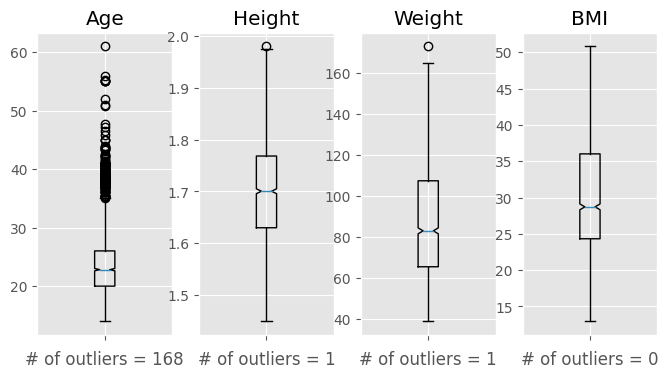

In [58]:
fig, ax = plt.subplots(1, 4, figsize = (8,4))
for idx, col in enumerate(columns, 0):  # <--- 0 is first row of image
    ax[idx].boxplot(data[col], 'o')
    ax[idx].set_title(col)
    ax[idx].set_xticklabels([])
    ax[idx].set_xlabel(f"# of outliers = {outlier[idx]}")

#### How to fix outlier

The outliers are treated by placing a cap between the quantiles. This reduces the number of cases to 1945 respondents, still relatively large for modelling.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


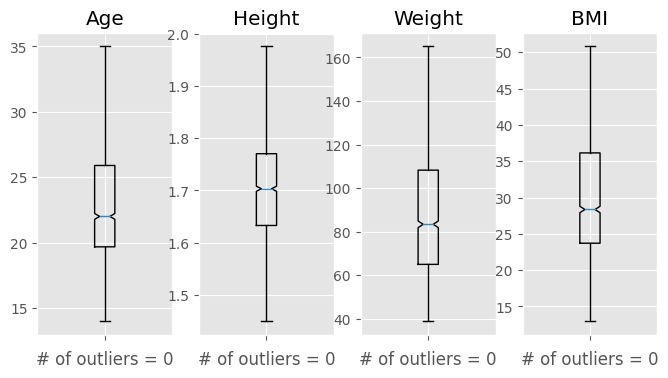

In [59]:
data = data[~((data < (lower_lim)) | (data > (upper_lim))).any(axis=1)]
outlier = ((data[columns] < (lower_lim)) | (data[columns] > (upper_lim))).sum()
fig, ax = plt.subplots(1, 4, figsize = (8,4))
for idx, col in enumerate(columns, 0):  
    ax[idx].boxplot(data[col], 'o')
    ax[idx].set_title(col)
    ax[idx].set_xticklabels([])
    ax[idx].set_xlabel(f"# of outliers = {outlier[idx]}")

---
##### Test of Normality 

The density plot provides a good visual judgment about whether the distribution of the variables is Gaussian. From the plots below, the distributions for most of the variables appear to be bell-shaped. While `Age` is skewed, a significance test for comparing the sample distribution to a normal one to ascertain whether data show or not a serious deviation from normality is conducted.

In this case, Shapiro-Wilk’s method is used as the normality test. It is on the correlation between the data and the corresponding normal scores. From the outputs, all the p-value > 0.05, suggesting that the distribution of the numeric data features is not significantly different from a normal distribution. In other words, the numeric features are assumed to have normality.

- The variables with skewness > 1 highly positively skewed.
- The variables with skewness < -1 are highly negatively skewed.
- The variables with 0.5 < skewness < 1 moderately positively skewed.
- The variables with -0.5 < skewness < -1 are moderately negatively skewed.
- And, the variables with -0.5 < skewness < 0.5 are symmetric i.e normally distributed.

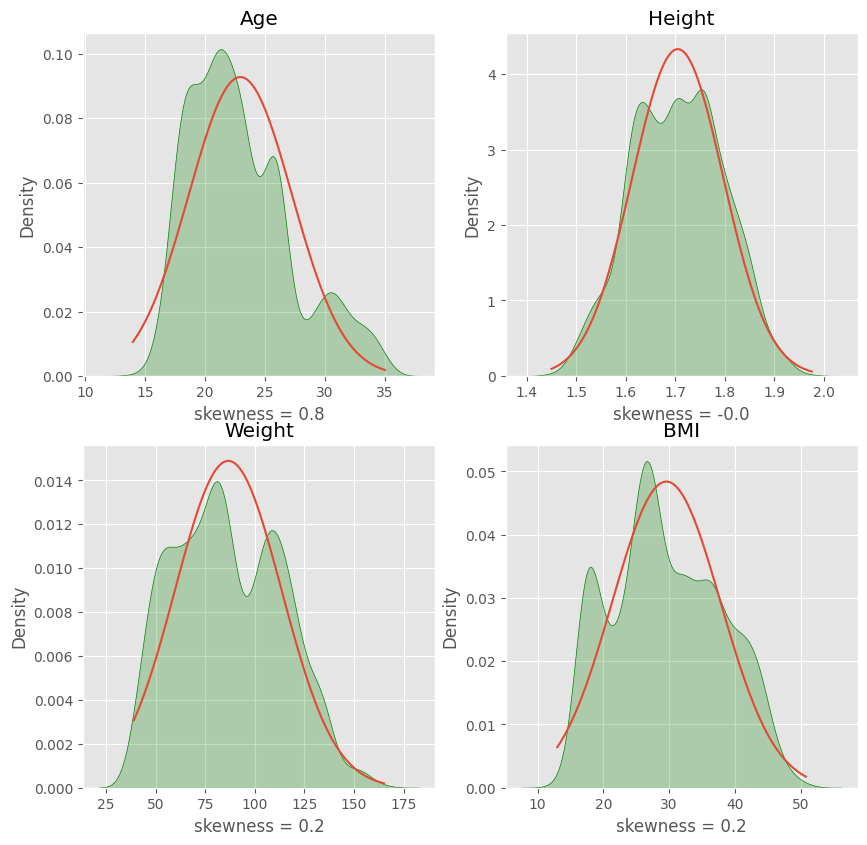

In [60]:
columns = ["Age","Height","Weight", "BMI"]
temp_skew = data[columns].skew()
# kernal density plots
fig, ax = plt.subplots(2, 2, figsize = (10,10))
axes = ax.ravel()
for col, ax in zip(columns, axes):
    sns.kdeplot(data[col], color="green", shade = True, ax=ax)
# superimpose normal distribution   
for i in range(4):
    axes[i].set_xlabel(f"skewness = {round(temp_skew[i],1)}")
    axes[i].set_title(f"{columns[i]}")
    
    mu, sigma = stats.norm.fit(data[columns[i]])
    bins = np.linspace(np.min(data[columns[i]]), np.max(data[columns[i]]), 100)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    axes[i].plot(bins, best_fit_line)

In [61]:
# test for normality on numerical variables
normal_var = []
spr = []
for i in range(len(numerical)):
    p = stats.shapiro(data[numerical[i]]).pvalue
    spr.append((numerical[i], (round(p,3))))
    if p > 0.05:
        normal_var.append((numerical[i]))

non_norm_var = list(set(numerical) - set(normal_var))

#### How to fix Normality

Boxcox is use to tranform the non-normal data variables so that it confirms to a normal distribution. The plot shows that the distribution are no longer considered skewed.

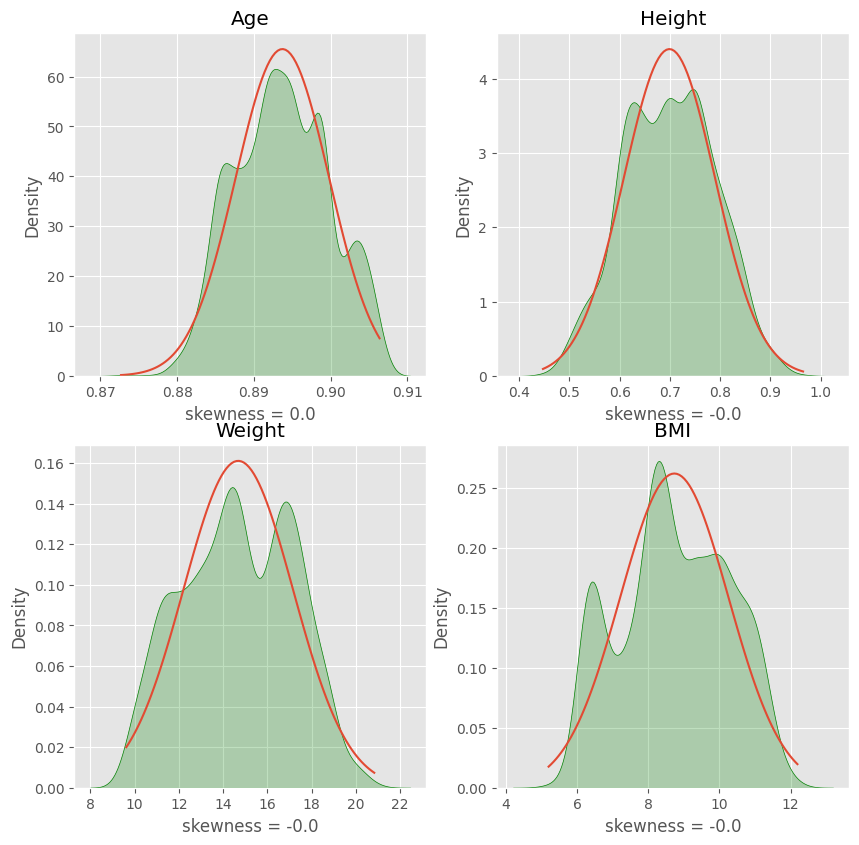

In [62]:
for i in non_norm_var:
    data[i], par = stats.boxcox(data[i])

# re-plot    
temp_skew = data[columns].skew()
fig, ax = plt.subplots(2, 2, figsize = (10,10))
axes = ax.ravel()
for col, ax in zip(columns, axes):
    sns.kdeplot(data[col], color="green", shade = True, ax=ax)   
for i in range(4):
    axes[i].set_xlabel(f"skewness = {round(temp_skew[i],1)}")
    axes[i].set_title(f"{columns[i]}")   
    mu, sigma = stats.norm.fit(data[columns[i]])
    bins = np.linspace(np.min(data[columns[i]]), np.max(data[columns[i]]), 100)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    axes[i].plot(bins, best_fit_line)

---
##### Correlation

The next step in the data exploration is the correlation matrix below which graphically represents the correlations between the predictor variables. The following computes a relevant measure of association between each and every feature. It calculates the correlation of features using Pearson’s R for continuous-continuous cases, Correlation Ratio for categorical-continuous cases, Cramer’s V or Theil’s U for categorical-categorical cases.

Overall, the variables were not strongly correlated with one another, except for `BMI` and `Weight` since it is expected that BMI would strongly correlate with weight. 

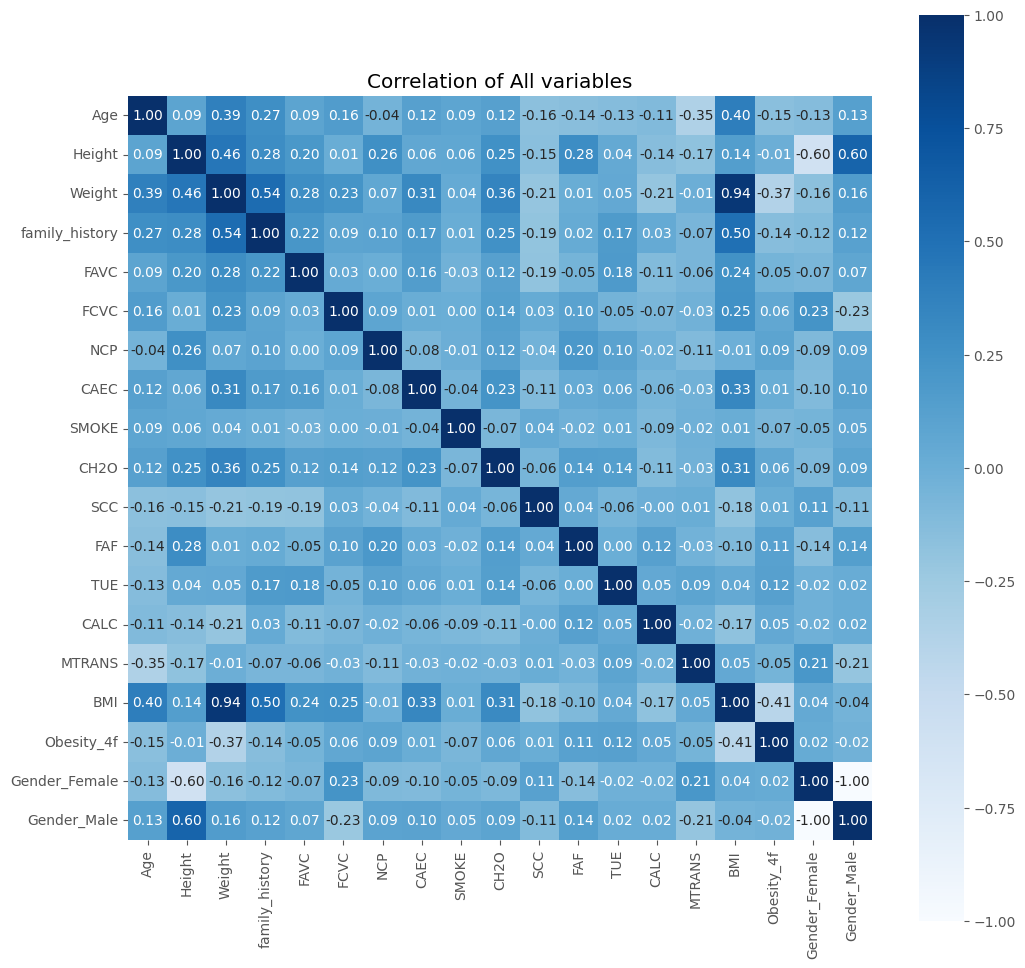

<AxesSubplot:title={'center':'Correlation of All variables'}>

In [63]:
corr = associations(data, fmt = '.2f', cmap = 'Blues', figsize = (12,12), title = "Correlation of All variables")
corr['ax']

#### How to fix Correlations

To build a smaller model without predictors with extremely high correlations, it is best to reduce the number of predictors such that there are no absolute pairwise correlations above 0.90. The list below shows only significant correlations (at 5% level) for the highest correlations by the correlation coefficient. The results show that there are 2 highly correlated pairs: `Weight` with `BMI` and `Gender_Female` with `Gender_Male`. With the latter begin a result of encoding, and taking into account that the model should not be learned to discriminate between gender, these will be removed. Lastly, `Weight` will be dropped to avoid collinearity.

In [64]:
temp = pd.DataFrame(np.triu(corr['corr'].to_numpy()))
# replace all corr < 0.85 with NaN
temp[abs(temp) < 0.85] = np.nan

temp = temp.rename_axis(None).rename_axis(None, axis=1)
temp = temp.stack().reset_index()
temp.columns = ['var1','var2','corr']
temp = temp.query('var1 != var2')
temp

,var1,var2,corr
3,2,15,0.943329
19,17,18,-1.000000


In [65]:
too_high = abs(temp['corr']) > 0.90
idx = too_high[too_high == True].index
to_drop = temp['var1'][idx].unique()
to_drop = np.append(to_drop, [15, 18])
# Drop features 
data_clean = data.drop(data.columns[[to_drop]], axis=1)
data_clean.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Age,Height,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_4f
0,0.891691,0.615314,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,3.0,3.0,0.0
1,0.891691,0.516620,1.0,0.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,0.0,2.0,3.0,0.0
2,0.894930,0.792524,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,3.0,0.0
3,0.899918,0.792524,0.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,4.0,2.0
4,0.893387,0.772860,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0



#### Group Imbalance

Lastly, while there is good balance among the target variable, `Obesity_4f`, it can be better. Using Synthetic Minority Oversampling Technique, or SMOTE, there is a synthesis of new minority instances between existing minority instances. It randomly picks up the minority class and calculates the K-nearest neighbour for that particular point. Finally, the synthetic points are added between the neighbours and the chosen spot.

In [66]:
sm = SMOTE(random_state = seed)
X_data = data_clean.drop(columns=['Obesity_4f'])
y_data = data_clean.filter(['Obesity_4f'])
X_res, y_res = sm.fit_resample(X_data, y_data)
  
X_res = pd.DataFrame(X_res)
Y_res = pd.DataFrame(y_res)

---
### Data Preparation 
Because of the properties that the data set possess that were established by the exploration tests, the data underwent various pre-processing steps to allow for accuracy and reliability during analysis. To recap:

1. There were no missing values.
2. Numerical variables that were skewed where transformed using Boxcox.
3. Highly correlated variables were dropped.
4. Gender was dropped due to possible unwelcome bias in the model.


#### Training & Testing Split

All the models built as a means to better classify individuals' BMI based on their eating and physical activities were trained on the same approximately 70% of the training set, reserving 30% for validation on the test set. 

In [67]:
train_X, test_X, train_y, test_y = train_test_split(X_res,
                                                    Y_res, 
                                                    test_size = 0.30,
                                                    random_state = seed)

### Building the models  

Before modeling the data, there needs to be an identification of which features are important since that can lead to better predictions and a parsimonious model. Feature selection is conducted to assist in choosing variables that are useful in predicting the response. 

The possible features that are impactful to classifying individuals' BMI are listed below. This was done by using the random forest algorithm to performs a top-down search for relevant features and comparing the original attributes' importance with the importance achievable at random. It shows that height, number of main meals, and age are indeed the most contributing variable. The least contributing is smoking.

In the end, it appears that all variables are confirmed to be important despite their rankings, therefore, they are all kept and models will be tuned for the best predictors.

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, oob_score = True, random_state = seed)
rf.fit(train_X, train_y)

importances = list(rf.feature_importances_)
feature_list = list(train_X.columns)

Text(0.5, 1.0, 'Variable Importances based on Random Forest Model')

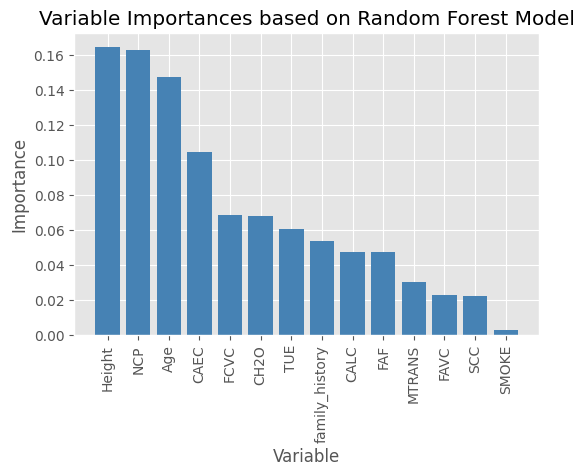

In [78]:
# Plot of RF Feature Importance
x_values = list(range(len(importances)))
df = pd.DataFrame({"feature_list": feature_list,"importances": importances})

plt.bar('feature_list', 'importances', data = df.sort_values('importances', ascending = False), color = 'steelblue')
plt.xticks(feature_list, rotation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable')
plt.title('Variable Importances based on Random Forest Model')

Three different learning algorithms are utilized. These include a 
- k-Nearest Neighbor, 
- Naive Bayes, and 
- Random Forest algorithms. 

These models are evaluated for the best fitting model capable of classifying individuals' BMI categories. The model accuracy rate is used to determine the best tuning. Accuracy is one minus the error rate and is thus the percentage of correctly classified observations. 

Moreover, to optimize each model, and with accuracy being the decision metric for the best performing model, a 10-fold cross-validation is run. By doing this, the training set is divided randomly into 10 parts and then each of 10 parts is used as a testing set for the model trained on other the 9. Then the average of the 10 error terms is obtained by performing the 10-fold CV three times. A repeated hold-out offers greater control than a simple k-fold and it is a very effective method to estimate the prediction error and the accuracy of a model. 

#### Model #1: k-Nearest Neighbor Classification

k-Nearest Neighbors is a classification algorithm that takes the new unlabeled data as input and determines the k closest labeled training data points, in other words, the k-nearest neighbors. The classification is decided by a majority vote, with ties broken at random. 

Average model accuracy: 0.84, (0.03)


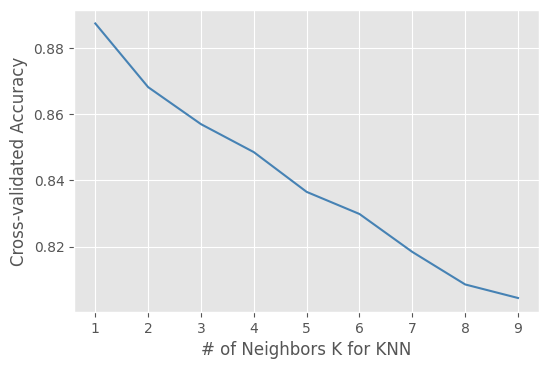

In [70]:
# cross-validation set up
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = seed)

# search for an optimal value of K for KNN
k_range = range(1, 10)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_X, train_y, scoring = 'accuracy', cv = cv, n_jobs = -1)
    k_scores.append(scores.mean())
    
plt.plot(k_range, k_scores, color = 'steelblue')
plt.xlabel('# of Neighbors K for KNN')
plt.ylabel('Cross-validated Accuracy')

# report performance
print(f'Average model accuracy: {round(np.mean(k_scores),2)}, ({round(np.std(k_scores),2)})')

In [71]:
# train with optimal k
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=1)

#### Model #2: Naive Bayes

The next model is Naive Bayes which uses estimated density by assuming that the inputs are conditionally independent in each class, i.e. Naive Bayes assumes that the features $X_1, X_2,…, X_p$ are independent given Y = k. Since the X's are assumed independent, it is assumed that there is no correlation between features. 

$[X \mid Y = k \sim N(\mu_k, \Sigma_k)]$

Thus, the theorem allows for the prediction of the class given a set of features using probability.

In [72]:
gnb = GaussianNB()
gnb.fit(train_X, train_y)
scores = cross_val_score(gnb, train_X, train_y, scoring = 'accuracy', cv = cv, n_jobs = -1)
nb_scores = scores.mean()

print(f'Average model accuracy: {round(np.mean(nb_scores),2)}, ({round(np.std(nb_scores),2)})')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Average model accuracy: 0.55, (0.0)


#### Model #3: Random Forest Classifier

Random Forest is use to classify the BMI categories. In this case, it is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [73]:
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = seed)
rf.fit(train_X, train_y)
scores = cross_val_score(rf, train_X, train_y, scoring = 'accuracy', cv = cv, n_jobs = -1)
rf_scores = scores.mean()

print(f'Average model accuracy: {round(np.mean(rf_scores),2)}, ({round(np.std(rf_scores),2)})')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Average model accuracy: 0.89, (0.0)


#### Model Evaluation 

The performance metrics were collected and analyzed to determine which model best fits the training data. After the 10 cross-validation, Random Forest outperforms the Naive Bayes and the KNN models, with the largest mean accuracy = 88%. This suggests that the overall accuracy of this model is substantially better than the expected random chance classifier’s accuracy.
 
From the results based on the test data, the kNN model with 1 neighbor, did exceptionally well in classifying the test set, while Naive Bayes and Random Forest did better than their resampling results. Of these three models, kNN can be considered the best fitting model for classifying individuals' eating and physical habits into BMI levels.

In [74]:
# Make predictions
knn_y_pred = knn.predict(test_X)
gbn_y_pred = gnb.predict(test_X)
rf_y_pred = rf.predict(test_X)

metrics = pd.DataFrame({'Models': ['KNN', 
                                   'Navie-Bayes',
                                   'Random-Forest'],
                        'Accuracy': [accuracy_score(test_y, knn_y_pred), 
                                     accuracy_score(test_y, gbn_y_pred), 
                                     accuracy_score(test_y, rf_y_pred)],
                        'Precision': [precision_score(test_y, knn_y_pred,average=None).round(2), 
                                      precision_score(test_y, gbn_y_pred,average=None).round(2), 
                                      precision_score(test_y, rf_y_pred,average=None).round(2)],
                        'Recall': [recall_score(test_y, knn_y_pred, average=None).round(2), 
                                   recall_score(test_y, gbn_y_pred, average=None).round(2), 
                                   recall_score(test_y, rf_y_pred, average=None).round(2)]
                       })

metrics

,Models,Accuracy,Precision,Recall
0,KNN,0.894938,"[0.87, 0.86, 0.91, 0.94]","[0.9, 0.89, 0.82, 0.97]"
1,Navie-Bayes,0.567335,"[0.65, 0.51, 0.52, 0.61]","[0.44, 0.93, 0.15, 0.77]"
2,Random-Forest,0.898758,"[0.84, 0.89, 0.9, 0.97]","[0.89, 0.94, 0.81, 0.96]"


#### The Optimal Model

The optimal model is an obvious decision. The kNN model does a more desirable job in classifying an individual's eating and physical activities into a BMI category of underweight, healthy, overweight, or obese on the test set. 

In terms of the confusion matrix, the results suggest that 89.4% of the predicted results seem to be correctly classified. The precision for each BMI level is also high for Obese at 87%, Overweight at 86%, and Healthy at 91%, while Underweight classification has a precision rate of 94%. Overall, this suggests that individuals belonging to an actual BMI level among all the levels predicted to be that particular level had little error. Moreover, the recall highlights that 97% of the Underwight bese individual have been correctly classified accordingly, whereas 82% of the Healthy individuals have been correctly classified, 89% of the Overweight individuals have been correctly classified and 90% of the Obese individuals have been correctly classified. In all, this model is capable of classifying an individual's eating and physical activities into one of the BMI categories. This is particularly true for those with habits the categorize them as being underweight, whereas the model appears to have some difficulty in classifying healthy individuals. 

In [76]:
df = pd.DataFrame(knn_y_pred)
tem = test_y.reset_index()
df['test'] = tem['Obesity_4f']
map_dict = {0: "obese", 1: "overweight", 2:"healthy", 3:"underweight"}
df["test_labels"] = df['test'].map(map_dict)
df["knn_labels"] = df[0].map(map_dict)
df.head(10)

,0,test,test_labels,knn_labels
0,1.0,1.0,overweight,overweight
1,1.0,2.0,healthy,overweight
2,1.0,1.0,overweight,overweight
3,1.0,1.0,overweight,overweight
4,0.0,0.0,obese,obese
5,3.0,3.0,underweight,underweight
6,2.0,1.0,overweight,healthy
7,3.0,3.0,underweight,underweight
8,0.0,0.0,obese,obese
9,0.0,0.0,obese,obese


[Text(0, 0.5, 'obese'),
 Text(0, 1.5, 'overweight'),
 Text(0, 2.5, 'health'),
 Text(0, 3.5, 'underweight')]

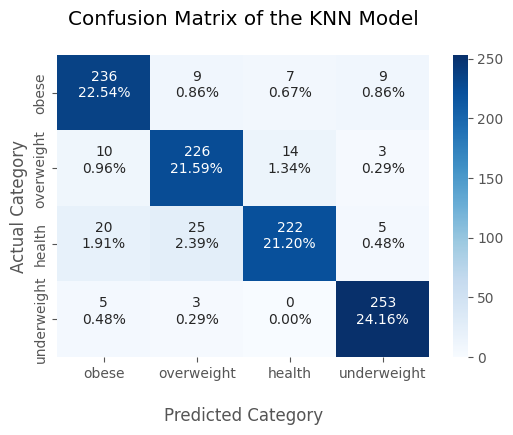

In [77]:
cm = confusion_matrix(test_y, knn_y_pred)

gp_count = ["{0:0.0f}".format(value) for value in cm.flatten()]
gp_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(gp_count, gp_percent)]
labels = np.asarray(labels).reshape(4,4)  # number of categories

ax = sns.heatmap(cm, annot = labels, fmt = '', cmap = 'Blues')
ax.set_title('Confusion Matrix of the KNN Model\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category');

ax.xaxis.set_ticklabels(['obese','overweight', 'health', 'underweight'])
ax.yaxis.set_ticklabels(['obese','overweight', 'health', 'underweight'])

### Conclusion
In conclusion, multiple models were built to better classify individuals’ BMI based on their eating and physical activities. Based on the test data, fitting a kNN model did exceptionally well in classifying individuals’ eating and physical habits into BMI levels, while a Naive Bayes and Random Forest model did not (kNN accuracy = 89%).